In [2]:
from jax import random, jit, config
config.update("jax_enable_x64", True)
config.update("jax_platform_name", "cpu")

import jax.numpy as jnp
import matplotlib.pyplot as plt

import tinygp
import jaxopt
import cosmogp

from numpy import intersect1d


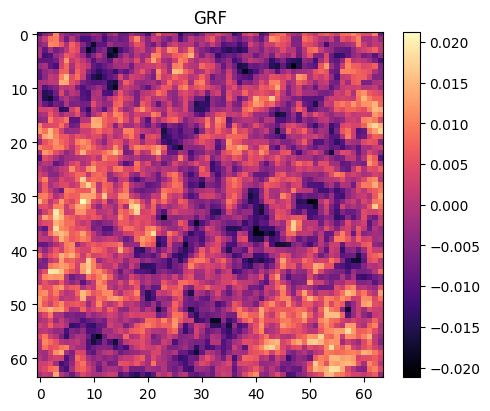

In [2]:
###################################################
# COSMOGP #########################################
###################################################
px = 64
L = 10 / 360 * 2 * jnp.pi
fiducialp = {"S8":0.8, "sigma8":0.8}
ocl = cosmogp.DiscreteCl(fiducialp, px, L)

# GRF REALISATION
key1, key2 = random.split(random.PRNGKey(34922))
grf = ocl.getgrf(key1, key2)

# PLOT
fig = plt.figure(figsize=(5,4), layout="constrained")
plt.imshow(grf, cmap='magma')
plt.title('GRF')
plt.colorbar()

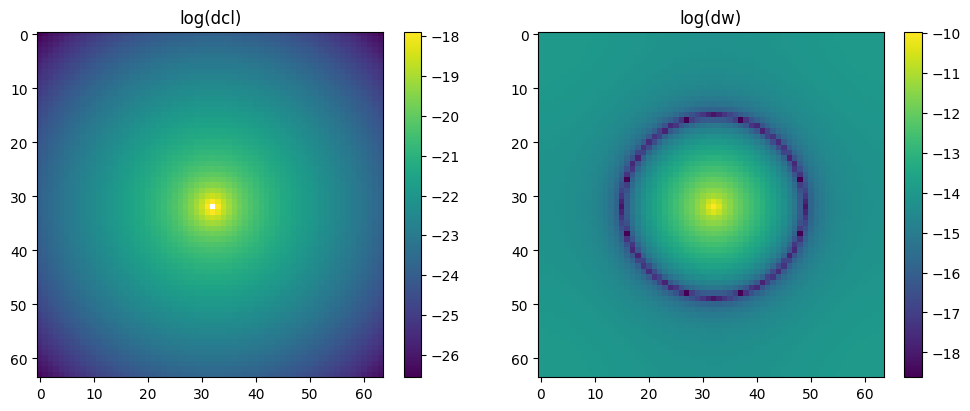

In [3]:
###################################################
# 2D EXTENSION OF CORRELATION FUNCTION ############
###################################################
dcl = ocl.getdcl(px, 1)
udw, dw = cosmogp.getw_FFT(dcl, L)

# PLOT
fig = plt.figure(figsize=(10,4), layout="constrained")
plt.subplot(121)
plt.imshow(jnp.log(dcl))
plt.title('log(dcl)')
plt.colorbar()

plt.subplot(122)
plt.imshow(jnp.log(dw))
plt.title('log(dw)')
plt.colorbar()

plt.show()

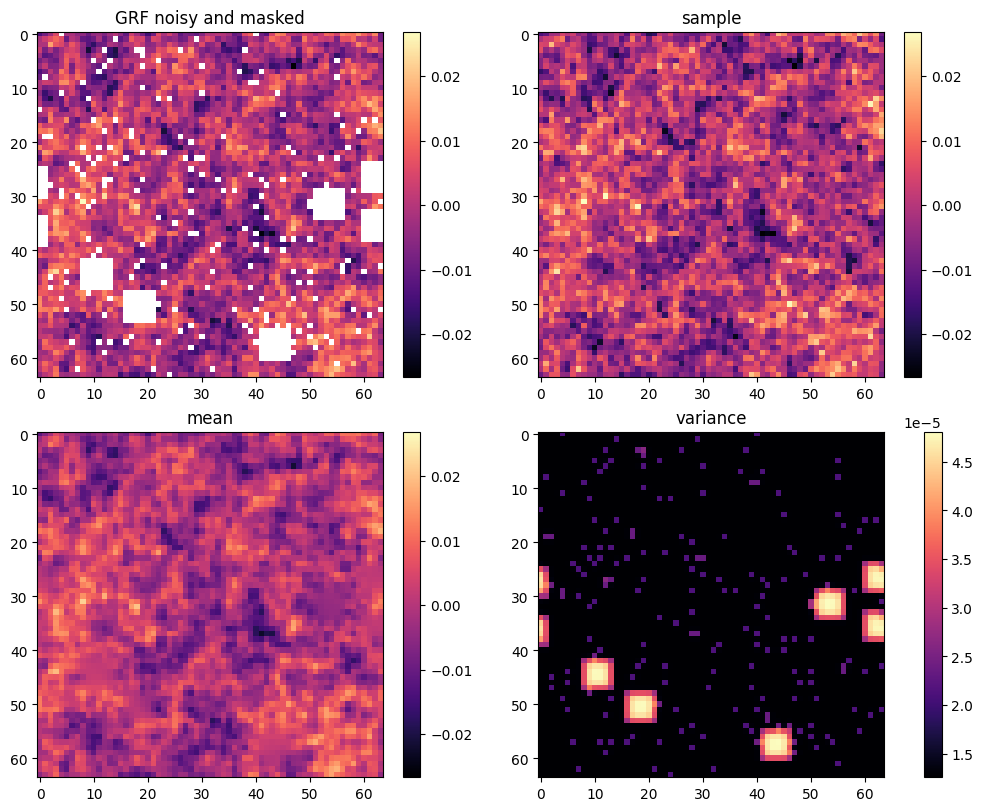

In [4]:
###################################################
# DATA GENERATION #################################
###################################################

# MASK
random_mask = cosmogp.getmask(
    key1, px, fsky=0.95, mask_id="random"
)
block_mask = cosmogp.getmask(key1, px, mask_id=6)
mask = intersect1d(random_mask, block_mask)

# NOISE
Larcmin = L * 3437.75  # arcmin
A_pixel = (Larcmin / px) ** 2  # pixel area in arcmin^2
sigma_epsilon = 0.26
n_galaxy = 100  # galaxies per arcmin^2
nbin = 1
noise_amplitude = sigma_epsilon / jnp.sqrt(n_galaxy * A_pixel / nbin)
noise = cosmogp.makenoise(key1, noise_amplitude, px)

# DATA
y = (grf+noise).flatten()[mask]
y_min, y_max = y.min(), y.max()

###################################################
# GP ##############################################
###################################################

# GRID
X_pred, x_, y_ = cosmogp.getgrid(px)
X = X_pred[mask]

# GP
diag = noise_amplitude**2
def build_gp(udw):
    kernel = cosmogp.Kernel2D(udw, px)
    return tinygp.GaussianProcess(kernel, X, diag=diag)

gp_cond = build_gp(udw).condition(y, X_pred, diag=diag).gp
sample = gp_cond.sample(key1, shape=(1,))

# PLOT 
fig = plt.figure(figsize=(10,8), layout="constrained")
plt.subplot(221)
plt.imshow(cosmogp.complete(y,mask,(px, px)), vmin=y_min, vmax=y_max, cmap='magma')
plt.title('GRF noisy and masked')
plt.colorbar()

plt.subplot(222)
plt.imshow(sample.reshape(px, px), vmin=y_min, vmax=y_max, cmap='magma')
plt.title('sample')
plt.colorbar()

plt.subplot(223)
plt.imshow(gp_cond.mean.reshape(px, px), vmin=y_min, vmax=y_max, cmap='magma')
plt.title('mean')
plt.colorbar()

plt.subplot(224)
plt.imshow(gp_cond.variance.reshape(px, px), cmap='magma')
plt.title('variance')
plt.colorbar()

plt.show()

In [7]:
###################################################
# OPTIMISATION ####################################
###################################################
@jit
def loss(p):
    ocl = cosmogp.DiscreteCl(p, px, L)
    dcl = ocl.getdcl(px, 1)
    udw, _ = cosmogp.getw_FFT(dcl, L)
    return -build_gp(udw).log_probability(y)

solver = jaxopt.ScipyMinimize(fun=loss)
initp = {"S8":1., "sigma8":0.6}
soln = solver.run(initp)
otimalp = soln.params
print(otimalp)

{'S8': Array(0.77864655, dtype=float64), 'sigma8': Array(0.66487076, dtype=float64)}


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Omega_m,0.353,0.143,0.174,0.628,0.004,0.003,1499.0,2479.0,1.0
S8,0.762,0.028,0.705,0.810,0.001,0.000,2397.0,2121.0,1.0
sigma8,0.745,0.151,0.493,1.000,0.004,0.003,1487.0,2446.0,1.0


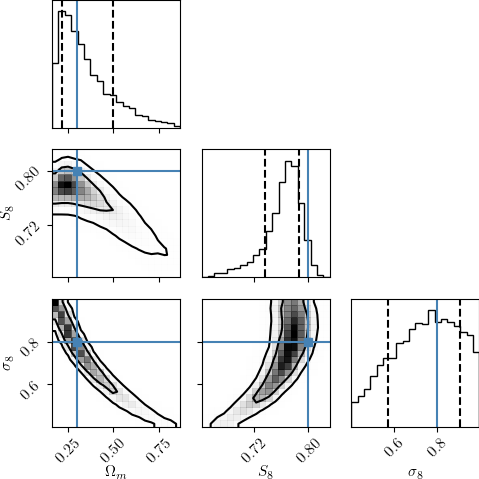

In [ ]:
###################################################
# ADDITIONAL COMPATIBILITIES ######################
###################################################
import numpyro
import arviz
import corner

###################################################
# NUMPYRO #########################################
###################################################
key_gp, key_mcmc = random.split(random.PRNGKey(34923))

def numpyro_model(keys, px, L, noise_amplitude, X, X_pred, y=None):
    # cosmological parameters
    fiducialp = {}
    if "S8" in keys:
        dist = numpyro.distributions.Uniform(0.565, 1.78)
        p["S8"] = numpyro.sample("S8", dist)
    if "sigma8" in keys:
        dist = numpyro.distributions.Uniform(0.4, 1.0)
        p["sigma8"] = numpyro.sample("sigma8", dist)
    if "Omega_m" in keys:
        dist = numpyro.distributions.Uniform(0.15, 0.95)
        p["Omega_m"] = numpyro.sample("Omega_m", dist)
    if all(key in keys for key in ["sigma8", "S8"]):
        Omega_m = numpyro.deterministic("Omega_m", 0.3 * (p["S8"] / p["sigma8"]) ** 2)
    elif all(key in keys for key in ["S8", "Omega_m"]):
        sigma8 = numpyro.deterministic("sigma8", p["S8"] / jnp.sqrt(p["Omega_m"] / 0.3))
    elif all(key in keys for key in ["sigma8", "Omega_m"]):
        S8 = numpyro.deterministic("S8", p["sigma8"] * jnp.sqrt(p["Omega_m"] / 0.3))

    # make GP
    ocl = cosmogp.DiscreteCl(p, px, L, filter=False)
    kernel = cosmogp.Kernel2D(ocl.getdcl(px, step=1), px, L)
    gp = tinygp.GaussianProcess(kernel, X, diag=noise_amplitude**2)

    # likelihood
    numpyro.sample("gp", gp.numpyro_dist(), obs=y)

    # posterior sampling
    cond = gp.condition(y, X_pred, diag=noise_amplitude**2)
    numpyro.deterministic("log_probability", cond.log_probability)
    numpyro.deterministic("mean", cond.gp.loc)
    numpyro.deterministic("std", jnp.sqrt(cond.gp.variance))
    numpyro.deterministic("sample", cond.gp.sample(key_gp, shape=(1,)))


nuts_kernel = numpyro.infer.NUTS(
        numpyro_model, dense_mass=True, max_tree_depth=16, target_accept_prob=0.8
    )
mcmc = numpyro.infer.MCMC(
    nuts_kernel,
    num_warmup=1000,
    num_samples=3000,
    num_chains=4,
    progress_bar=True,
)

mcmc.run(
    key_mcmc,
    {"S8", "Omega_m"},
    px,
    L,
    noise_amplitude,
    X,
    X_pred,
    y=y,
)

# ARVIZ
arviz.from_numpyro(mcmc).to_netcdf("mcmc_arviz.nc")

###################################################
# PLOT ############################################
###################################################
data_mcmc = arviz.from_netcdf("mcmc_arviz.nc")
var_names = ["Omega_m", "S8", "sigma8"]

# compress data
data_raw = arviz.extract(data_mcmc, var_names=var_names)
data_compressed = (
    data_raw.to_dataframe()
    .drop(["chain", "draw"], axis=1)
    .reset_index()
    .drop(["chain", "draw"], axis=1)
)
data_compressed = data_compressed.rename(
    columns={"Omega_m": r"$\Omega_m$", "S8": r"$S_8$", "sigma8": r"$\sigma_8$"}
)

# CORNER
CORNER_KWARGS = dict(
    smooth=0.7,
    quantiles=[0.16, 0.84],
    levels=(0.65, 0.95),
    plot_datapoints=False,
    min_n_ticks=3,
    max_n_ticks=3,
)

fig = corner.corner(
    data_compressed,
    var_names=[r"$\Omega_m$", r"$S_8$", r"$\sigma_8$"],
    color="black",
    **CORNER_KWARGS,
    truths={
        r"$S_8$": fiducialp["S8"],
        r"$\sigma_8$": fiducialp["sigma8"],
        r"$\Omega_m$": 0.3
        * (fiducialp["S8"] / fiducialp["sigma8"]) ** 2,
    },
)

arviz.summary(data_mcmc, var_names=var_names)